In [1]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
psi4.core.set_output_file('output.dat', False)
import time


In [2]:
# setup basic arguments for qed-ci calculation

# z-matrix for LIH
mol_str = """
Li
H 1 1.8
symmetry c1
"""

# options for Psi4
options_dict = {
    "basis": "sto-3g",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
}

# options for the PFHamiltonian Generator class - include cavity effects
cavity_dict = {
    'omega_value' : 0.2, #0.12086,
    'lambda_vector' : np.array([0, 0, 0.05]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 1, #<== this is a minimal photon basis, should explore increasing this 
}

# options for PFHamiltonian Generator class - exclude cavity effects
cavity_free_dict = {
    'omega_value' : 0.0,
    'lambda_vector' : np.array([0, 0, 0.0]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 0, 
}



In [3]:
# template for the z-matrix so we can scan through bond lengths
mol_tmpl = """
Li
H 1 **R**
symmetry c1
"""


# number of bondlengths in the scan
N_R = 50

# number of electronic states to save
N_el = 10

r_array = np.linspace(1.4, 2.2, N_R)

# array for energies for LiH outside cavity
cavity_free_E_array = np.zeros((N_R, N_el))

# array  for energies inside the cavity
cavity_E_array = np.zeros((N_R, N_el))

r_idx = 0
for r in r_array:
    mol_str = mol_tmpl.replace("**R**", str(r))
    mol = psi4.geometry(mol_str)
    print(mol_str)
    
    # call psi4 RHF
    scf_e, wfn = psi4.energy('SCF/sto-3g', return_wfn=True)
    
    # call psi4 FCI
    fci_energy = psi4.energy('fci/sto-3g',ref_wfn=wfn)
    
    # LiH no cavity
    LiH = PFHamiltonianGenerator(mol_str, options_dict, cavity_free_dict)

    # check to make sure PFHamiltonian cavity-free FCI ground-state agrees with psi4
    assert np.isclose(LiH.CIeigs[0], fci_energy)
    
    # LiH with cavity
    LiH_cav = PFHamiltonianGenerator(mol_str, options_dict, cavity_dict)
    cavity_free_E_array[r_idx,:] = LiH.CIeigs[:N_el]
    cavity_E_array[r_idx,:] = LiH_cav.CIeigs[:N_el]
    r_idx += 1





Li
H 1 1.4
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -12.6946346236295966
CQED-RHF One-electron energy      = -12.6946346236295966
Nuclear repulsion energy          = 1.1339511657214287
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8605386610570420   dE = -7.86054E+00   dRMS = 1.78618E-13
SCF Iteration   2: Energy = -7.8605386610570562   dE = -1.42109E-14   dRMS = 3.97012E-14
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.86053866 hartree
Psi4  SCF energy: -7.86053866 hartree
 Completed QED-RHF in 0.08255815505981445 seconds
 Completed 1HSO Build in 5.793571472167969e-05 seconds
 Completed ERI Build in 0.001135110855102539 seconds 
 Completed 2D build in 7.987022399902344e-05 seconds
 Completed 1G build in 1.4066696166992188e-05 seconds
 Completed the Dipole Matrix Build in 3.790855407714844e-05 seconds
 Completed determinant list in 0.00045013427734375 seconds 
 Completed constant offset matri

 Completed Hamiltonian build in 0.6850159168243408 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.6287313839641655
CQED-RHF One-electron energy      = -12.6146241668066708
Nuclear repulsion energy          = 1.0956204220914088
Dipole energy                     = 0.0133021859905870
SCF Iteration   1: Energy = -7.8585748001843108   dE = -7.85857E+00   dRMS = 3.19483E-04
SCF Iteration   2: Energy = -7.8585802740071067   dE = -5.47382E-06   dRMS = 4.81411E-05
SCF Iteration   3: Energy = -7.8585805708506999   dE = -2.96844E-07   dRMS = 1.74248E-05
SCF Iteration   4: Energy = -7.8585806211330720   dE = -5.02824E-08   dRMS = 1.98485E-07
SCF Iteration   5: Energy = -7.8585806211343350   dE = -1.26299E-12   dRMS = 2.67705E-09
SCF Iteration   6: Energy = -7.8585806211343368   dE = -1.77636E-15   dRMS = 1.60695E-10
SCF Iteration   7: Energy = -7.8585806211343332   dE =  3.55271E-15   dRMS = 2.40047E-14
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.85

 Completed Hamiltonian build in 0.6925256252288818 seconds

Li
H 1 1.5142857142857142
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -12.5445686059622048
CQED-RHF One-electron energy      = -12.5445686059622048
Nuclear repulsion energy          = 1.0483699456669811
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8633796323248477   dE = -7.86338E+00   dRMS = 3.97097E-13
SCF Iteration   2: Energy = -7.8633796323248459   dE =  1.77636E-15   dRMS = 8.98898E-14
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.86337963 hartree
Psi4  SCF energy: -7.86337963 hartree
 Completed QED-RHF in 0.08240008354187012 seconds
 Completed 1HSO Build in 5.316734313964844e-05 seconds
 Completed ERI Build in 0.0010950565338134766 seconds 
 Completed 2D build in 9.393692016601562e-05 seconds
 Completed 1G build in 1.5020370483398438e-05 seconds
 Completed the Dipole Matrix Build in 3.695487976074219e-05 seconds
 Completed determ

 Completed Hamiltonian build in 0.6846048831939697 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.4840645825416985
CQED-RHF One-electron energy      = -12.4687906839341807
Nuclear repulsion energy          = 1.0155228455416452
Dipole energy                     = 0.0142641414367342
SCF Iteration   1: Energy = -7.8586059008307361   dE = -7.85861E+00   dRMS = 3.28515E-04
SCF Iteration   2: Energy = -7.8586134440445479   dE = -7.54321E-06   dRMS = 7.34157E-05
SCF Iteration   3: Energy = -7.8586142711272222   dE = -8.27083E-07   dRMS = 2.72762E-05
SCF Iteration   4: Energy = -7.8586143933046104   dE = -1.22177E-07   dRMS = 4.06321E-07
SCF Iteration   5: Energy = -7.8586143933139825   dE = -9.37206E-12   dRMS = 7.32141E-09
SCF Iteration   6: Energy = -7.8586143933139825   dE =  0.00000E+00   dRMS = 3.50526E-10
SCF Iteration   7: Energy = -7.8586143933139825   dE =  0.00000E+00   dRMS = 2.84514E-13
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.85

 Completed Hamiltonian build in 0.7011251449584961 seconds

Li
H 1 1.6285714285714286
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -12.4066585131691234
CQED-RHF One-electron energy      = -12.4066585131691234
Nuclear repulsion energy          = 0.9748001249184212
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8608053993812623   dE = -7.86081E+00   dRMS = 2.49968E-15
SCF Iteration   2: Energy = -7.8608053993812588   dE =  3.55271E-15   dRMS = 6.89060E-16
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.86080540 hartree
Psi4  SCF energy: -7.86080540 hartree
 Completed QED-RHF in 0.08419919013977051 seconds
 Completed 1HSO Build in 5.0067901611328125e-05 seconds
 Completed ERI Build in 0.001119852066040039 seconds 
 Completed 2D build in 7.915496826171875e-05 seconds
 Completed 1G build in 1.5020370483398438e-05 seconds
 Completed the Dipole Matrix Build in 3.910064697265625e-05 seconds
 Completed determ

 Completed Hamiltonian build in 0.6863198280334473 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.3509124121235860
CQED-RHF One-electron energy      = -12.3343604454357294
Nuclear repulsion energy          = 0.9463388074025544
Dipole energy                     = 0.0152899234897717
SCF Iteration   1: Energy = -7.8538861104179407   dE = -7.85389E+00   dRMS = 3.53972E-04
SCF Iteration   2: Energy = -7.8538972751166458   dE = -1.11647E-05   dRMS = 1.02967E-04
SCF Iteration   3: Energy = -7.8538990250419189   dE = -1.74993E-06   dRMS = 3.54240E-05
SCF Iteration   4: Energy = -7.8538992316682421   dE = -2.06626E-07   dRMS = 6.47485E-07
SCF Iteration   5: Energy = -7.8538992316952516   dE = -2.70095E-11   dRMS = 1.12209E-08
SCF Iteration   6: Energy = -7.8538992316952552   dE = -3.55271E-15   dRMS = 5.66477E-10
SCF Iteration   7: Energy = -7.8538992316952534   dE =  1.77636E-15   dRMS = 1.03916E-12
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.85

 Completed Hamiltonian build in 0.701225996017456 seconds

Li
H 1 1.7428571428571429
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -12.2794744734878893
CQED-RHF One-electron energy      = -12.2794744734878893
Nuclear repulsion energy          = 0.9108788052516398
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8543451780812763   dE = -7.85435E+00   dRMS = 4.20329E-15
SCF Iteration   2: Energy = -7.8543451780812763   dE =  0.00000E+00   dRMS = 1.14543E-15
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.85434518 hartree
Psi4  SCF energy: -7.85434518 hartree
 Completed QED-RHF in 0.08488607406616211 seconds
 Completed 1HSO Build in 4.887580871582031e-05 seconds
 Completed ERI Build in 0.001093149185180664 seconds 
 Completed 2D build in 6.985664367675781e-05 seconds
 Completed 1G build in 1.4066696166992188e-05 seconds
 Completed the Dipole Matrix Build in 3.695487976074219e-05 seconds
 Completed determin

 Completed Hamiltonian build in 0.693220853805542 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.2279483802846372
CQED-RHF One-electron energy      = -12.2100018912759438
Nuclear repulsion energy          = 0.8859800679782459
Dipole energy                     = 0.0163800577987572
SCF Iteration   1: Energy = -7.8457444370658438   dE = -7.84574E+00   dRMS = 3.94997E-04
SCF Iteration   2: Energy = -7.8457611988938316   dE = -1.67618E-05   dRMS = 1.35902E-04
SCF Iteration   3: Energy = -7.8457643825213141   dE = -3.18363E-06   dRMS = 4.26091E-05
SCF Iteration   4: Energy = -7.8457646861419610   dE = -3.03621E-07   dRMS = 9.34272E-07
SCF Iteration   5: Energy = -7.8457646862023962   dE = -6.04352E-11   dRMS = 1.57266E-08
SCF Iteration   6: Energy = -7.8457646862023980   dE = -1.77636E-15   dRMS = 8.82321E-10
SCF Iteration   7: Energy = -7.8457646862023998   dE = -1.77636E-15   dRMS = 3.23326E-12
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.845

 Completed Hamiltonian build in 0.7007031440734863 seconds

Li
H 1 1.8571428571428572
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -12.1618316008527394
CQED-RHF One-electron energy      = -12.1618316008527394
Nuclear repulsion energy          = 0.8548247249284615
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8451135004582042   dE = -7.84511E+00   dRMS = 5.66790E-15
SCF Iteration   2: Energy = -7.8451135004582131   dE = -8.88178E-15   dRMS = 1.46803E-15
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.84511350 hartree
Psi4  SCF energy: -7.84511350 hartree
 Completed QED-RHF in 0.08509469032287598 seconds
 Completed 1HSO Build in 5.602836608886719e-05 seconds
 Completed ERI Build in 0.001155853271484375 seconds 
 Completed 2D build in 0.00014781951904296875 seconds
 Completed 1G build in 1.52587890625e-05 seconds
 Completed the Dipole Matrix Build in 3.886222839355469e-05 seconds
 Completed determinant

 Completed Hamiltonian build in 0.7049357891082764 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.1140896355219141
CQED-RHF One-electron energy      = -12.0946288755094429
Nuclear repulsion energy          = 0.8328592073714133
Dipole energy                     = 0.0175313664510865
SCF Iteration   1: Energy = -7.8351523691474334   dE = -7.83515E+00   dRMS = 4.49882E-04
SCF Iteration   2: Energy = -7.8351772503822179   dE = -2.48812E-05   dRMS = 1.72236E-04
SCF Iteration   3: Energy = -7.8351825199277716   dE = -5.26955E-06   dRMS = 4.96992E-05
SCF Iteration   4: Energy = -7.8351829449223249   dE = -4.24995E-07   dRMS = 1.29824E-06
SCF Iteration   5: Energy = -7.8351829450474444   dE = -1.25119E-10   dRMS = 2.18133E-08
SCF Iteration   6: Energy = -7.8351829450474533   dE = -8.88178E-15   dRMS = 1.54408E-09
SCF Iteration   7: Energy = -7.8351829450474533   dE =  0.00000E+00   dRMS = 1.07116E-11
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.83

 Completed Hamiltonian build in 0.6977119445800781 seconds

Li
H 1 1.9714285714285715
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -12.0527718772287926
CQED-RHF One-electron energy      = -12.0527718772287926
Nuclear repulsion energy          = 0.8052696684108697
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8339309662690466   dE = -7.83393E+00   dRMS = 4.48769E-15
SCF Iteration   2: Energy = -7.8339309662690555   dE = -8.88178E-15   dRMS = 1.22912E-15
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.83393097 hartree
Psi4  SCF energy: -7.83393097 hartree
 Completed QED-RHF in 0.08588480949401855 seconds
 Completed 1HSO Build in 4.887580871582031e-05 seconds
 Completed ERI Build in 0.0010848045349121094 seconds 
 Completed 2D build in 8.511543273925781e-05 seconds
 Completed 1G build in 1.4066696166992188e-05 seconds
 Completed the Dipole Matrix Build in 3.695487976074219e-05 seconds
 Completed determ

 Completed Hamiltonian build in 0.6819579601287842 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.0084616458771727
CQED-RHF One-electron energy      = -11.9873653796840660
Nuclear repulsion energy          = 0.7857479794796969
Dipole energy                     = 0.0187372469857856
SCF Iteration   1: Energy = -7.8228257145205005   dE = -7.82283E+00   dRMS = 5.16946E-04
SCF Iteration   2: Energy = -7.8228619207582186   dE = -3.62062E-05   dRMS = 2.12258E-04
SCF Iteration   3: Energy = -7.8228700972835830   dE = -8.17653E-06   dRMS = 5.75176E-05
SCF Iteration   4: Energy = -7.8228706896019924   dE = -5.92318E-07   dRMS = 1.77444E-06
SCF Iteration   5: Energy = -7.8228706898551623   dE = -2.53170E-10   dRMS = 3.15402E-08
SCF Iteration   6: Energy = -7.8228706898551943   dE = -3.19744E-14   dRMS = 3.15829E-09
SCF Iteration   7: Energy = -7.8228706898551943   dE =  0.00000E+00   dRMS = 3.69400E-11
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.82

 Completed Hamiltonian build in 0.6937179565429688 seconds

Li
H 1 2.085714285714286
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -11.9515180443788669
CQED-RHF One-electron energy      = -11.9515180443788669
Nuclear repulsion energy          = 0.7611453030184931
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8214062070316768   dE = -7.82141E+00   dRMS = 2.41434E-13
SCF Iteration   2: Energy = -7.8214062070316892   dE = -1.24345E-14   dRMS = 6.43390E-14
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.82140621 hartree
Psi4  SCF energy: -7.82140621 hartree
 Completed QED-RHF in 0.08588910102844238 seconds
 Completed 1HSO Build in 5.0067901611328125e-05 seconds
 Completed ERI Build in 0.0011000633239746094 seconds 
 Completed 2D build in 8.606910705566406e-05 seconds
 Completed 1G build in 1.4781951904296875e-05 seconds
 Completed the Dipole Matrix Build in 3.719329833984375e-05 seconds
 Completed determ

 Completed Hamiltonian build in 0.699639081954956 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -11.9103500847605517
CQED-RHF One-electron energy      = -11.8874971816595831
Nuclear repulsion energy          = 0.7436811660467495
Dipole energy                     = 0.0199878191937224
SCF Iteration   1: Energy = -7.8092950554534726   dE = -7.80930E+00   dRMS = 5.95073E-04
SCF Iteration   2: Energy = -7.8093466496293766   dE = -5.15942E-05   dRMS = 2.56456E-04
SCF Iteration   3: Energy = -7.8093587578151622   dE = -1.21082E-05   dRMS = 6.68327E-05
SCF Iteration   4: Energy = -7.8093595966866980   dE = -8.38872E-07   dRMS = 2.40118E-06
SCF Iteration   5: Energy = -7.8093595971950096   dE = -5.08312E-10   dRMS = 4.94049E-08
SCF Iteration   6: Energy = -7.8093595971951357   dE = -1.26121E-13   dRMS = 7.10312E-09
SCF Iteration   7: Energy = -7.8093595971951393   dE = -3.55271E-15   dRMS = 1.23038E-10
SCF Iteration   8: Energy = -7.8093595971951411   dE = -1.77636E-15   d

 Completed Hamiltonian build in 0.6900038719177246 seconds

Li
H 1 2.2
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -11.8574277515713256
CQED-RHF One-electron energy      = -11.8574277515713256
Nuclear repulsion energy          = 0.7216052872772727
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8079943691480995   dE = -7.80799E+00   dRMS = 6.19450E-15
SCF Iteration   2: Energy = -7.8079943691480995   dE =  0.00000E+00   dRMS = 1.79775E-15
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.80799437 hartree
Psi4  SCF energy: -7.80799437 hartree
 Completed QED-RHF in 0.08498024940490723 seconds
 Completed 1HSO Build in 5.125999450683594e-05 seconds
 Completed ERI Build in 0.0010929107666015625 seconds 
 Completed 2D build in 7.081031799316406e-05 seconds
 Completed 1G build in 1.621246337890625e-05 seconds
 Completed the Dipole Matrix Build in 3.790855407714844e-05 seconds
 Completed determinant list in 0.

In [4]:
from matplotlib import pyplot as plt

First plot the ground-state potential energy surfaces for LiH inside and outisde the cavity.  The effect of the cavity will raise the energy slightly.

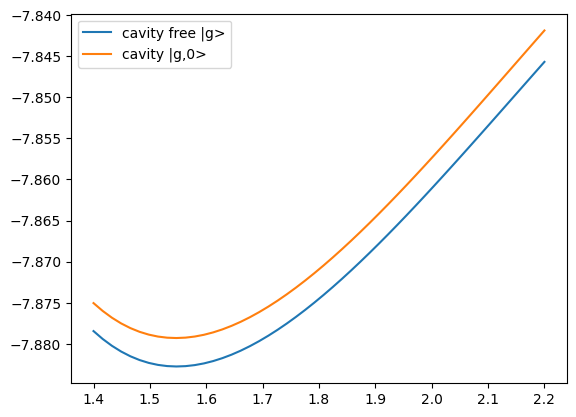

In [5]:
plt.plot(r_array, cavity_free_E_array[:,0], label='cavity free |g>')
plt.plot(r_array, cavity_E_array[:,0], label='cavity |g,0>')
plt.legend()
plt.show()


Next plot the ground state surface shifted by the cavity energy and the first excited state surface of 
LiH outside the cavity along with the lower- and upper-polariton surfaces from LiH inside the cavity.
Note that lower polariton surface intersects with another surface for the molecule in the cavity (see the crossing of the red and green curves around r = 1.5 Angstroms); the polariton surface is smooth, so we should really re-sort the eigenvalues around this point. Ruby has some experience doing this. 

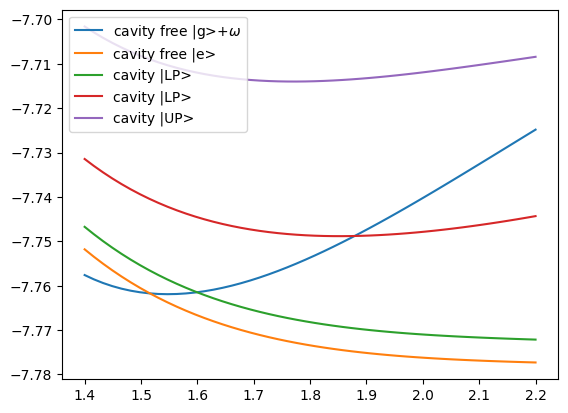

In [6]:
plt.plot(r_array, cavity_free_E_array[:,0]+0.12086, label='cavity free |g>+$\omega$')
plt.plot(r_array, cavity_free_E_array[:,1], label='cavity free |e>')
plt.plot(r_array, cavity_E_array[:,1], label='cavity |LP>')
plt.plot(r_array, cavity_E_array[:,2], label='cavity |LP>')
plt.plot(r_array, cavity_E_array[:,3], label='cavity |UP>')
plt.legend()
plt.show()